In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [12]:
df=pd.read_csv("../../data/merged/len3_ship_mon_DN.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

C:\Users\hakos\AppData\Local\Temp\ipykernel_23376\1186495989.py:1: DtypeWarning: Columns (6,9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../../data/merged/len3_ship_mon_DN.csv",encoding="shift-jis",index_col=0)


0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4195    2022-08-31
4196    2022-09-30
4197    2022-10-31
4198    2022-11-30
4199    2022-12-31
Name: ship_date, Length: 4200, dtype: object

Estimation

In [13]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4195    0
4196    0
4197    0
4198    0
4199    0
Name: mon_1, Length: 4200, dtype: uint8

In [14]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [15]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2867 entries, (114, Timestamp('2009-02-28 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 641 entries, year to year_trend
dtypes: float64(14), int32(3), int64(603), object(9), uint8(12)
memory usage: 13.8+ MB


(641, 167, 19)

In [16]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [17]:
before_p=10*12
after_p=15*12
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m120+elapsed_m119+elapsed_m118+elapsed_m117+elapsed_m116+elapsed_m115+elapsed_m114+elapsed_m113+elapsed_m112+elapsed_m111+elapsed_m110+elapsed_m109+elapsed_m108+elapsed_m107+elapsed_m106+elapsed_m105+elapsed_m104+elapsed_m103+elapsed_m102+elapsed_m101+elapsed_m100+elapsed_m99+elapsed_m98+elapsed_m97+elapsed_m96+elapsed_m95+elapsed_m94+elapsed_m93+elapsed_m92+elapsed_m91+elapsed_m90+elapsed_m89+elapsed_m88+elapsed_m87+elapsed_m86+elapsed_m85+elapsed_m84+elapsed_m83+elapsed_m82+elapsed_m81+elapsed_m80+elapsed_m79+elapsed_m78+elapsed_m77+elapsed_m76+elapsed_m75+elapsed_m74+elapsed_m73+elapsed_m72+elapsed_m71+elapsed_m70+elapsed_m69+elapsed_m68+elapsed_m67+elapsed_m66+elapsed_m65+elapsed_m64+elapsed_m63+elapsed_m62+elapsed_m61+elapsed_m60+elapsed_m59+elapsed_m58+elapsed_m57+elapsed_m56+elapsed_m55+elapsed_m54+elapsed_m53+elapsed_m52+elapsed_m51+elapsed_m50+elapsed_m49+elapsed_m48+elapsed_m47+elapsed_m46+elapsed_m45+elapsed_m44+elapsed_m43+elapsed_m42+elapsed_m41+elapsed_m40+elapse

## RX

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m120         0.0098     0.1638     0.0598     0.9524     -0.3114      0.3309
elapsed_m119         0.1266     0.1863     0.6796     0.4968     -0.2387      0.4920
elapsed_m118        -0.0449     0.1844    -0.2433     0.8078     -0.4065      0.3167
elapsed_m117         0.1398     0.2381     0.5871     0.5572     -0.3271      0.6067
elapsed_m116        -0.0649     0.2254    -0.2878     0.7736     -0.5068      0.3771
elapsed_m115         0.0311     0.1880     0.1652     0.8688     -0.3375      0.3996
elapsed_m114         0.0062     0.2560     0.0241     0.9808     -0.4958      0.5081
elapsed_m113        -0.0236     0.1921    -0.1231     0.9021     -0.4004      0.3531
elapsed_m112         0.2026     0.1914     1.0584     0.2900     

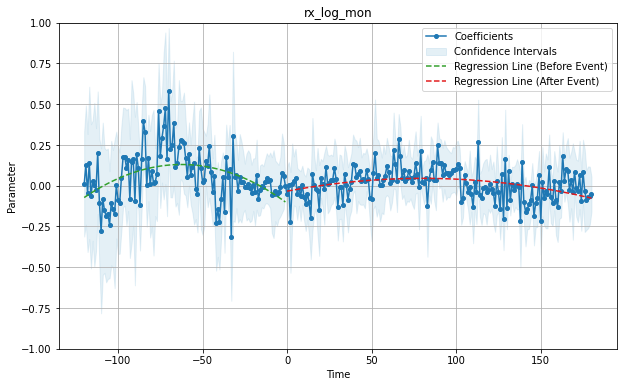

In [18]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="rx_log_mon",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elapsed_m120          0.4728     0.4142     1.1414     0.2538     -0.3395      1.2850
elapsed_m119         -0.0854     0.3703    -0.2307     0.8176     -0.8116      0.6408
elapsed_m118         -0.2138     0.3257    -0.6563     0.5117     -0.8525      0.4249
elapsed_m117         -0.4945     0.8947    -0.5527     0.5805     -2.2490      1.2599
elapsed_m116         -0.2214     0.3175    -0.6974     0.4856     -0.8441      0.4013
elapsed_m115         -0.1901     0.3526    -0.5392     0.5898     -0.8814      0.5012
elapsed_m114         -0.6896     0.4213    -1.6369     0.1018     -1.5158      0.1365
elapsed_m113          0.0965     0.2514     0.3839     0.7011     -0.3965      0.5895
elapsed_m112          0.4861     0.3751     1.2959    

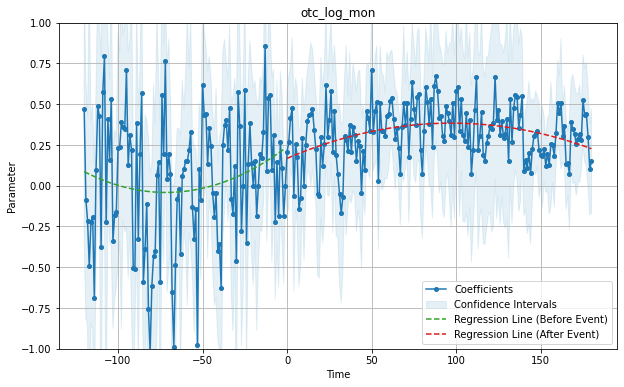

In [19]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_otc_lag
formula+=" + log_stock_otc_lag"

# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="otc_log_mon",plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)